##### Include libraries

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt
# equals: from matplotlib import pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

import pandas as pd # primary data structure library
import numpy as np # useful for many scientific computing in Python
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from pywaffle import Waffle
import folium
from folium import plugins

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats as stats

from PIL import Image # converting images into arrays

import plotly.express as px
import plotly.graph_objects as go

Using matplotlib in Jupyter Notebooks, requires the graph to be displayed inside the notebook interface itself. It is, therefore, essential to add the following 'magic' statement after loading the library.

In [ ]:
%matplotlib inline

##### Read a CSV file with or without header

In [3]:
filepath = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(filepath) # Includes header in CSV file

filepath = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Data%20files/auto.csv"
df = pd.read_csv(filepath, header=None) # No header in CSV file

##### Apply header to dataframe

In [4]:
headers = ["symboling","normalized-losses","make","fuel-type","aspiration", "num-of-doors","body-style",
         "drive-wheels","engine-location","wheel-base", "length","width","height","curb-weight","engine-type",
         "num-of-cylinders", "engine-size","fuel-system","bore","stroke","compression-ratio","horsepower",
         "peak-rpm","city-mpg","highway-mpg","price"]
df.columns = headers # Assign headers to dataframe

##### Display first or last rows of dataframe

In [ ]:
df.head(5) # Display first 5 rows of dataframe
df.tail(5) # Display last 5 rows of dataframe

##### Identify columns with empty data cells

In [ ]:
# replace "?" to NaN
df.replace("?", np.nan, inplace = True)

# The output is a boolean value for each cell indicating whether the value 
# that is passed into the argument is in fact missing data.
# .notnull() can be used as well.
missing_data = df.isnull()

# Count missing values in each column
for column in missing_data.columns.values.tolist():
    # print(column)
    print (missing_data[column].value_counts())
    print("")

# DataFrame example indicating missing values:
#       A      B      C
# 0  False  False  False
# 1  False   True  False
# 2   True  False  False
# 3  False  False   True

In [ ]:
# Missing values in attributes that have continuous data are best replaced using Mean value
avg_weight=df['Weight_kg'].astype('float').mean(axis=0)
df["Weight_kg"].replace(np.nan, avg_weight, inplace=True)

In [ ]:
# Missing values in attributes that have categorical data are best replaced using the most frequent value
common_screen_size = df['Screen_Size_cm'].value_counts().idxmax()
df["Screen_Size_cm"].replace(np.nan, common_screen_size, inplace=True)

##### "normalized-losses": 41 missing data, replace them with mean

In [6]:
# Calculate the average of the column 'normalized-losses'
avg_norm_loss = df["normalized-losses"].astype("float").mean(axis=0)
print("Average of normalized-losses:", avg_norm_loss)

# Replace NaN by mean value in "normalized-losses" column
df["normalized-losses"].replace(np.nan, avg_norm_loss, inplace=True)

Average of normalized-losses: 122.0


##### Replace NaN with the most common value for the column

In [7]:
most_used_value = df['num-of-doors'].value_counts().idxmax()
df["num-of-doors"].replace(np.nan, most_used_value, inplace=True)

##### Drop all rows that do not have price data

In [8]:
# The subset parameter in the dropna method of a pandas DataFrame 
# is used to specify which columns to consider when determining whether 
# to drop a row or not. When you use dropna with the subset parameter, 
# only the specified columns are checked for missing values (NaNs). 
# If any of the specified columns contain NaNs, the corresponding row 
# will be dropped.
df.dropna(subset=["price"], axis=0, inplace=True)
# reset index, because we dropped rows
df.reset_index(drop=True, inplace=True)

##### Convert data types to proper format

In [9]:
df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float")
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")

##### Normalize "length", "width" and "height" to fall in the range of [0,1]

In [10]:
df['length'] = df['length']/df['length'].max()
df['width'] = df['width']/df['width'].max()
df['height'] = df['height']/df['height'].max()

##### Binning is a process of creating a categorical attribute which splits the values of a continuous data into a specified number of groups. In this case, write a code to create 3 bins for the attribute "Price". These bins would be named "Low", "Medium" and "High". The new attribute will be named "Price-binned".

Text(0.5, 1.0, 'Price bins')

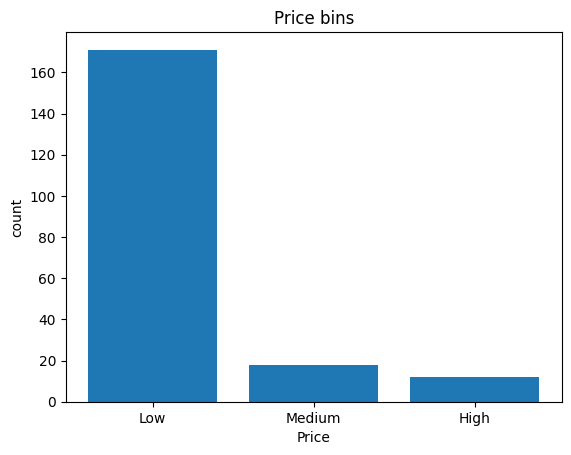

In [11]:
import pandas as pd
import matplotlib.pylab as plt
# equals: from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

bins = np.linspace(min(df["price"]), max(df["price"]), 4)
group_names = ['Low', 'Medium', 'High']
df['Price-binned'] = pd.cut(df['price'], bins, labels=group_names, include_lowest=True )

plt.bar(group_names, df["Price-binned"].value_counts())
plt.xlabel("Price")
plt.ylabel("count")
plt.title("Price bins")

##### Add bool values for column content 'fuel-type'

In [12]:
dummy_variable_1 = pd.get_dummies(df["fuel-type"])

# change column names for clarity
dummy_variable_1.rename(columns={'gas':'fuel-type-gas', 'diesel':'fuel-type-diesel'}, inplace=True)

# merge data frame "df" and "dummy_variable_1"
df = pd.concat([df, dummy_variable_1], axis=1)

# drop original column "fuel-type" from "df"
df.drop("fuel-type", axis = 1, inplace=True)

##### Find the correlation between the following columns: bore, stroke, compression-ratio, and horsepower.

In [13]:
df[['bore', 'stroke', 'compression-ratio', 'horsepower']].corr()

,bore,stroke,compression-ratio,horsepower
bore,1.000000,-0.055390,0.001250,0.568527
stroke,-0.055390,1.000000,0.187923,0.100040
compression-ratio,0.001250,0.187923,1.000000,-0.214576
horsepower,0.568527,0.100040,-0.214576,1.000000


##### Plot engine size as potential predictor variable of price

(0.0, 53075.1867401442)

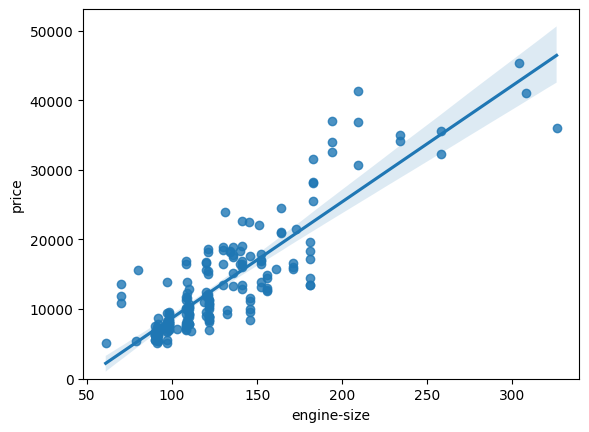

In [ ]:
# "regplot" plots the scatterplot plus the fitted regression line 
# for the data
sns.regplot(x="engine-size", y="price", data=df)
plt.ylim(0,)

 We can examine the correlation between 'engine-size' and 'price' and see that it's approximately 0.87.


In [15]:
df[["engine-size", "price"]].corr()

,engine-size,price
engine-size,1.000000,0.872335
price,0.872335,1.000000


##### Categorical variables

These are variables that describe a 'characteristic' of a data unit, and are selected from a small group of categories. The categorical variables can have the type "object" or "int64". A good way to visualize categorical variables is by using boxplots.

The maximum value of the graph is typically 1.5 times the top value of the box. The minimum value is typically 1.5 times the lowest value of the box.

<Axes: xlabel='body-style', ylabel='price'>

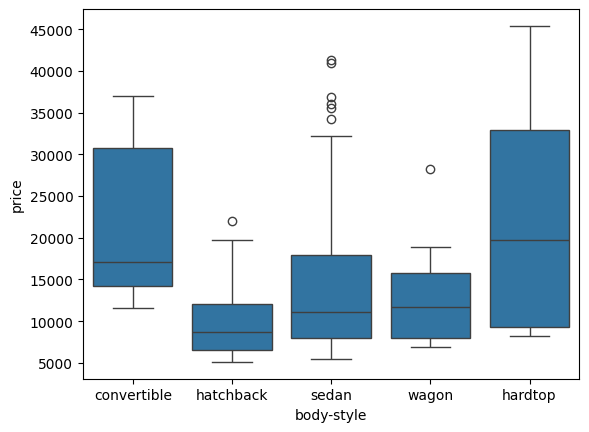

In [16]:
sns.boxplot(x="body-style", y="price", data=df)

We see that the distributions of price between the different body-style categories have a significant overlap, so body-style would not be a good predictor of price.

<Axes: xlabel='engine-location', ylabel='price'>

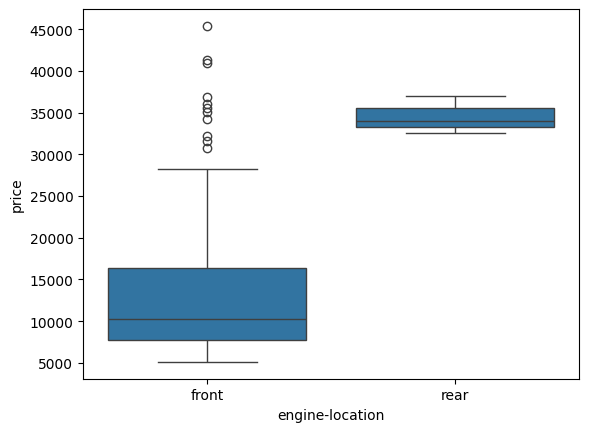

In [17]:
sns.boxplot(x="engine-location", y="price", data=df)

Here we see that the distribution of price between these two engine-location categories, front and rear, are distinct enough to take engine-location as a potential good predictor of price.

##### Descriptive Statistical Analysis

The describe function automatically computes basic statistics for all continuous variables. Any NaN values are automatically skipped in these statistics.

In [ ]:
# The default setting of "describe" skips variables of type object.
# We can apply the method "describe" on the variables of type 'object' 
# as follows:

df.describe(include=['object'])
# df.describe()
# df.describe(include='all')

,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,horsepower,peak-rpm
count,201,201,201,201,201,201,201,201,201,199,199
unique,22,2,2,5,3,2,6,7,8,58,22
top,toyota,std,four,sedan,fwd,front,ohc,four,mpfi,68,5500
freq,32,165,115,94,118,198,145,157,92,19,36


Value counts is a good way of understanding how many units of each characteristic/variable we have. We can apply the "value_counts" method on the column "drive-wheels". Don’t forget the method "value_counts" only works on pandas series, not pandas dataframes. As a result, we only include one bracket <code>df['drive-wheels']</code>, not two brackets <code>df[['drive-wheels']]</code>.

In [23]:
df['drive-wheels'].value_counts()

# We can convert the series to a dataframe as follows:
drive_wheels_counts = df['drive-wheels'].value_counts().to_frame()
# Change the column header
drive_wheels_counts.rename(columns={'drive-wheels': 'value_counts'}, inplace=True)
# Change the index header
drive_wheels_counts.index.name = 'drive-wheels'
drive_wheels_counts

,count
drive-wheels,
fwd,118
rwd,75
4wd,8


We can do the same process for the variable 'engine-location'.


In [24]:
# engine-location as variable
engine_loc_counts = df['engine-location'].value_counts().to_frame()
engine_loc_counts.rename(columns={'engine-location': 'value_counts'}, inplace=True)
engine_loc_counts.index.name = 'engine-location'
engine_loc_counts.head(10)

,count
engine-location,
front,198
rear,3


After examining the value counts of the engine location, we see that engine location would not be a good predictor variable for the price. This is because we only have three cars with a rear engine and 198 with an engine in the front, so this result is skewed. Thus, we are not able to draw any conclusions about the engine location.

##### Basics of grouping

In [25]:
# Let's group by the variable "drive-wheels". 
# We see that there are 3 different categories of drive wheels.
print(df['drive-wheels'].unique())

['rwd' 'fwd' '4wd']


In [29]:
# If we want to know, on average, which type of drive wheel is most valuable, we can group "drive-wheels" and then average them.
# We can select the columns 'drive-wheels', 'body-style' and 'price', 
# then assign it to the variable "df_group_one".
df_gptest = df[['drive-wheels','body-style','price']]
grouped_test1 = df_gptest.groupby(['drive-wheels','body-style'],as_index=False).mean()
grouped_test1

,drive-wheels,body-style,price
0,4wd,hatchback,7603.000000
1,4wd,sedan,12647.333333
2,4wd,wagon,9095.750000
3,fwd,convertible,11595.000000
4,fwd,hardtop,8249.000000
5,fwd,hatchback,8396.387755
6,fwd,sedan,9811.800000
7,fwd,wagon,9997.333333
8,rwd,convertible,23949.600000
9,rwd,hardtop,24202.714286


This grouped data is much easier to visualize when it is made into a pivot table. A pivot table is like an Excel spreadsheet, with one variable along the column and another along the row. We can convert the dataframe to a pivot table using the method "pivot" to create a pivot table from the groups.

In [30]:
grouped_pivot = grouped_test1.pivot(index='drive-wheels',columns='body-style')
grouped_pivot

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  NaN           NaN   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222

In [31]:
grouped_pivot = grouped_pivot.fillna(0) #fill missing values with 0
grouped_pivot

price                                            \
body-style   convertible       hardtop     hatchback         sedan   
drive-wheels                                                         
4wd                  0.0      0.000000   7603.000000  12647.333333   
fwd              11595.0   8249.000000   8396.387755   9811.800000   
rwd              23949.6  24202.714286  14337.777778  21711.833333   

                            
body-style           wagon  
drive-wheels                
4wd            9095.750000  
fwd            9997.333333  
rwd           16994.222222

##### Heatmap

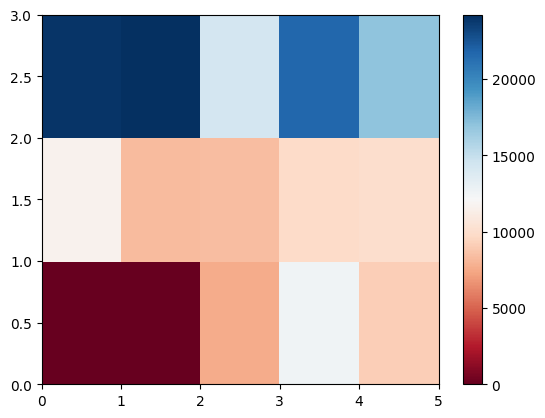

In [32]:
#use the grouped results
plt.pcolor(grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

The default labels convey no useful information to us. Let's change that:

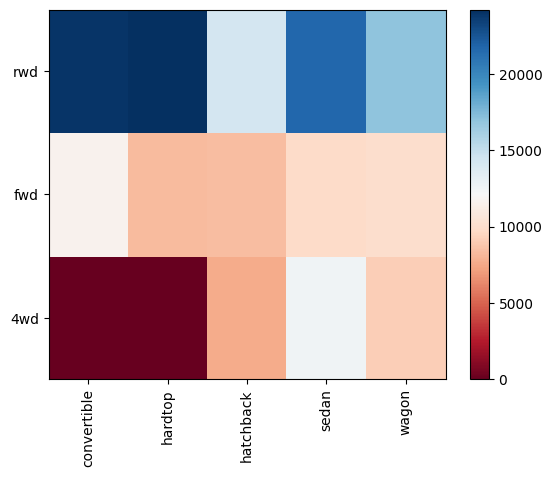

In [33]:
fig, ax = plt.subplots()
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

##### Correlation and Causation

Pearson Correlation is the default method of the function "corr". Like before, we can calculate the Pearson Correlation of the of the 'int64' or 'float64'  variables.

In [ ]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 
# 'wheel-base' and 'price'. 
pearson_coef, p_value = stats.pearsonr(df['wheel-base'], df['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

Since the p-value is $<$ 0.001, the correlation between wheel-base and price is statistically significant, although the linear relationship isn't extremely strong (~0.585).

##### Singular Linear Regression (SLR) example

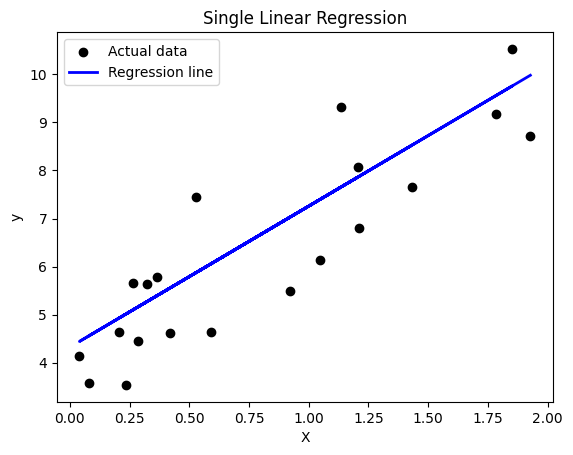

Intercept: 4.322358530421342
Coefficient: 2.936471507826248
Mean Squared Error: 1.0434333815695165
R^2 Score: 0.7424452332071367


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 2: Create a sample dataset
# For demonstration purposes, we'll create a simple dataset
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data=np.hstack((X, y)), columns=['X', 'y'])

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['X']], df['y'], test_size=0.2, random_state=0)

# Step 4: Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Visualize the results
plt.scatter(X_test, y_test, color='black', label='Actual data')
plt.plot(X_test, y_pred, color='blue', linewidth=2, label='Regression line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Single Linear Regression')
plt.legend()
plt.show()

# Print model coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

This example demonstrates how to perform single linear regression using scikit-learn in Python. The steps include creating a dataset, splitting the data, training the model, making predictions, visualizing the results, and evaluating the model's performance.

Step-by-Step Guide
- Import the Required Libraries: Import the necessary libraries for data manipulation, visualization, and linear regression.
- Create or Load the Dataset: Create a sample dataset or load an existing one.
- Split the Data: Split the data into training and testing sets.
- Create and Train the Model: Create a linear regression model and train it on the training data.
- Make Predictions: Use the trained model to make predictions on the test data.
- Visualize the Results: Plot the regression line and the data points.

##### Formula to select the best variables based on correlation results

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Select variables with high correlation with the target variable 'price'
threshold = 0.3
target_variable = 'price'
correlated_vars = correlation_matrix[target_variable][abs(correlation_matrix[target_variable]) > threshold].index.tolist()

# Remove the target variable from the list of correlated variables
correlated_vars.remove(target_variable)

# correlated_vars now contains the variables that are highly correlated 
# with the target variable 'price'
print(correlated_vars)

##### Multiple Linear Regression (MLR) example

Mean Squared Error: 0.7093845759110854
R^2 Score: 0.967458726465977
Intercept: 4.456378604528259
Coefficients: [2.64776793 4.90767648]


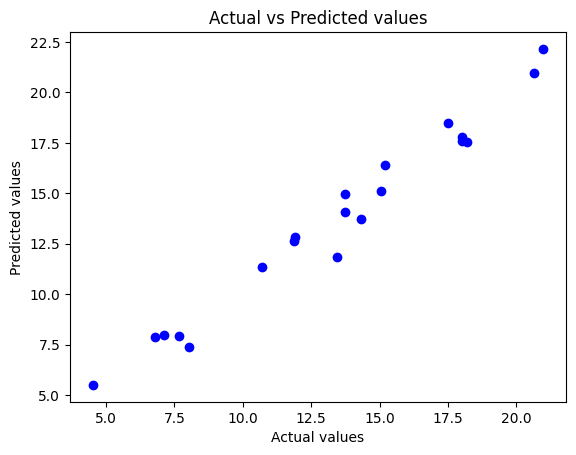

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Step 2: Create a sample dataset
# For demonstration purposes, we'll create a simple dataset
np.random.seed(0)
X1 = 2 * np.random.rand(100, 1)
X2 = 3 * np.random.rand(100, 1)
y = 4 + 3 * X1 + 5 * X2 + np.random.randn(100, 1)

# Combine X1 and X2 into a single array
X = np.hstack((X1, X2))

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data=np.hstack((X, y)), columns=['X1', 'X2', 'y'])

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['X1', 'X2']], df['y'], test_size=0.2, random_state=0)

# Step 4: Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print model coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

# Step 7: Visualize the results (optional)
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted values")
plt.show()

This example demonstrates how to perform multiple linear regression using scikit-learn in Python. The steps include creating a dataset, splitting the data, training the model, making predictions, evaluating the model's performance, and optionally visualizing the results.

Step-by-Step Guide
-Import the Required Libraries: Import the necessary libraries for data manipulation, visualization, and linear regression.
- Create or Load the Dataset: Create a sample dataset or load an existing one.
- Split the Data: Split the data into training and testing sets.
- Create and Train the Model: Create a linear regression model and train it on the training data.
- Make Predictions: Use the trained model to make predictions on the test data.
- Evaluate the Model: Evaluate the model's performance using metrics like Mean Squared Error (MSE) and R-squared (R²).
- Visualize the Results: Optionally, visualize the results.

##### Annotations

In [ ]:
df_iceland.plot(kind='bar', figsize=(10, 6), rot=90)

plt.xlabel('Year')
plt.ylabel('Number of Immigrants')
plt.title('Icelandic Immigrants to Canada from 1980 to 2013')

# Annotate arrow
plt.annotate('',  # s: str. will leave it blank for no text
             xy=(32, 70),  # place head of the arrow at point (year 2012 , pop 70)
             xytext=(28, 20),  # place base of the arrow at point (year 2008 , pop 20)
             xycoords='data',  # will use the coordinate system of the object being annotated
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2)
             )

# Annotate Text
plt.annotate('2008 - 2011 Financial Crisis',  # text to display
             xy=(28, 30),  # start the text at at point (year 2008 , pop 30)
             rotation=72.5,  # based on trial and error to match the arrow
             va='bottom',  # want the text to be vertically 'bottom' aligned
             ha='left',  # want the text to be horizontally 'left' algned.
             )

plt.show()

In [ ]:
# generate plot
df_top15.plot(kind='barh', figsize=(12, 12), color='steelblue')
plt.xlabel('Number of Immigrants')
plt.title('Top 15 Conuntries Contributing to the Immigration to Canada between 1980 - 2013')

# annotate value labels to each country
for index, value in enumerate(df_top15): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value - 47000, index - 0.10), color='white')

plt.show()

##### Waffle chart

In [ ]:
df_ci = df_can.loc[['China', 'India'], :]

#Set up the Waffle chart figure
fig = plt.figure(FigureClass = Waffle,
                 rows = 20, columns = 30, #pass the number of rows and columns for the waffle 
                 values = df_ci.Total, #pass the data to be used for display
                 cmap_name = 'tab20', #color scheme
                 legend = {'labels': [f"{k} ({v})" for k, v in zip(df_ci.index.values,df_ci.Total)],
                            'loc': 'lower left', 'bbox_to_anchor':(0,-0.1),'ncol': 3}
                 #notice the use of list comprehension for creating labels 
                 #from index and total of the dataset
                )

#Display the waffle chart
plt.show()

##### Use of plotly.graph_objects and plotly.express

In [ ]:
# Import required libraries
import pandas as pd
import plotly.graph_objects as go
import numpy as np

age_array=np.random.randint(25,55,60)
income_array=np.random.randint(300000,700000,3000000)
##First we will create an empty figure using go.Figure()
fig=go.Figure()
# Next we will create a scatter plot by using the add_trace function and use 
# the go.scatter() function within it
# In go.Scatter we define the x-axis data,y-axis data and define the mode as markers with color of the marker as blue
fig.add_trace(go.Scatter(x=age_array, y=income_array, mode='markers', marker=dict(color='blue')))
## Here we update these values under function attributes such as title,xaxis_title and yaxis_title
fig.update_layout(title='Economic Survey', xaxis_title='Age', yaxis_title='Income')
# Display the figure
fig.show()

In [ ]:
# Import required libraries
import pandas as pd
import plotly.graph_objects as go
import numpy as np

numberofbicyclessold_array=[50,100,40,150,160,70,60,45]
months_array=["Jan","Feb","Mar","April","May","June","July","August"]
fig=go.Figure()
# Next we will create a line plot by using the add_trace function and use 
# the go.scatter() function within it
# In go.Scatter we define the x-axis data,y-axis data and define the mode as lines 
# with color of the marker as green
fig.add_trace(go.Scatter(x=months_array, y=numberofbicyclessold_array, mode='lines', marker=dict(color='green')))
# Here we update these values under function attributes such as title,xaxis_title and yaxis_title
fig.update_layout(title='Bicycle Sales', xaxis_title='Months', yaxis_title='Number of Bicycles Sold')
# Display the figure
fig.show()

In [ ]:
# Import required libraries
import pandas as pd
import plotly.express as px
import numpy as np

score_array=[80,90,56,88,95] 
grade_array=['Grade 6','Grade 7','Grade 8','Grade 9','Grade 10']
# Use plotly express bar chart function px.bar.Provide input data, x and y axis variable,
# and title of the chart.
# This will give average pass percentage per class
fig = px.bar( x=grade_array, y=score_array, title='Pass Percentage of Classes') 
fig.show()

In [ ]:
# Import required libraries
import pandas as pd
import plotly.express as px
import numpy as np

heights_array = np.random.normal(160, 11, 200)
## Use plotly express histogram chart function px.histogram.Provide input data x 
# to the histogram
fig = px.histogram(x=heights_array,title="Distribution of Heights")
fig.show()